# Transform Longitude Values

## Introduction

Many climate datasets have longitude coordinates from 0 to 360. This is not suitable to be used in other raster based geoprocessing systems. This notebook shows how to convert such datasets to span longitude from -180 to +180 and save it as a GeoTIFF file suitable for analysis in GIS software.

## Overview of the Task
We take a NetCDF file of Monthly Precipitation by [ECMWF ERA5-Land Monthly Average](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview) dataset. This file has global monthly precipitation for the month of July, 2021. We reproject the longitude coordinates and save the result as a GeoTIFF file.

**Input Layers**:
* `era5-land-precipitation.nc`: A NetCDF file containing monthly average precipitation with longitude coordinates from 0-360.

**Output**:
* `precipitation.tif`: A reprojected GeoTiff file of total monthly precpitation with longitudes from -180 to +180.

**Data Credit**:
* Muñoz Sabater, J., (2019): ERA5-Land monthly averaged data from 1981 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). (Accessed on < 05-Aug-2022 >), 10.24381/cds.68d2bb3

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray netcdf4 cartopy

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import pandas as pd
import rioxarray as rxr
import xarray as xr

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

filename = 'era5-land-precipitation.nc'
data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

download(data_url + filename)

## Procedure

Open the input file with XArray.

In [ ]:
input_path = os.path.join(data_folder, filename)
ds = xr.open_dataset(input_path)
ds

<xarray.Dataset> Size: 52MB
Dimensions:    (longitude: 3600, latitude: 1801, time: 1)
Coordinates:
  * longitude  (longitude) float32 14kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 8B 2021-07-01
Data variables:
    tp         (time, latitude, longitude) float64 52MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 17:45:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Notice the `longitude` coordinates have have values from 0 to 360. We convert the longitude to range from -180 to +180. Many downstream packages expect the coordinates to be sorted in ascening order, so we also sort the resulting longitude values.

In [ ]:
ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
ds = ds.sortby(ds.longitude)
ds

<xarray.Dataset> Size: 52MB
Dimensions:    (latitude: 1801, time: 1, longitude: 3600)
Coordinates:
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 8B 2021-07-01
  * longitude  (longitude) float32 14kB -180.0 -179.9 -179.8 ... 179.8 179.9
Data variables:
    tp         (time, latitude, longitude) float64 52MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 17:45:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Notice the `longitude` coordinates have have values from -180 to +180. The dataset is now ready to be saved. But before saving, we can also convert the units to be more usable. The input dataset's units are *meters/day*, so we multiply by 1000 and the number of days in the month to get total precipitation in *mm/month*. [[reference](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790)]

Calculate the number of days in the month using the Pandas [`pd.Period`](https://pandas.pydata.org/docs/reference/api/pandas.Period.html).

In [ ]:
time = ds.time.values[0]
ts = pd.to_datetime(time).strftime('%Y-%m-%d')
days = pd.Period(ts).days_in_month
print(f'Number of days in month of {ts}: {days}')

Number of days in month of 2021-07-01: 31


Select the variable `tp` (total precipitation) and convert the units.

In [ ]:
da = ds['tp']
da_prcp = da * 1000 * days

We have just 1 value of time, so use `squeeze()` to remove the empty time dimension and get a 2D array.

In [ ]:
da_prcp = da_prcp.squeeze()

Visualize the results using CartoPy on an Equal Earth projection.

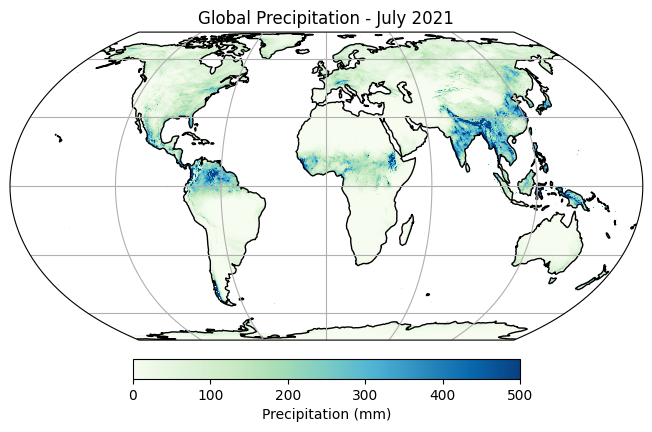

In [ ]:
projection = ccrs.EqualEarth()
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})
fig.set_size_inches(10,5)

# Plot the data
plot = da_prcp.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Data is in PlateCarree
    cmap='GnBu',
    vmin=0, vmax=500,
    add_colorbar=False)

# Add a custom colorbar
cbar = fig.colorbar(plot, ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label('Precipitation (mm)')
# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Set title
ax.set_title('Global Precipitation - July 2021')

# Show the plot
plt.show()

Finally save the results as a GeoTIFF file.

In [ ]:
output_file = 'precipitation.tif'
output_path = os.path.join(output_folder, output_file)
da_prcp.rio.to_raster(output_path, compress='LZW')

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>